In [1]:
import tensorflow as tf
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout
from keras.models import Model
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

2023-11-08 00:57:28.554937: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-08 00:57:28.554969: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-08 00:57:28.554995: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-08 00:57:28.561927: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
CONFIGURATION = {
    "H_NRNS":16,
    "IM_SIZE":224,
    "BATCH SIZE":32,
    "N_EPOCH":50
}

# Data movement

In [3]:
val_files = []
for i in range(430):
    val_files.append('Img_{}.jpg'.format(i))

val_files[1]

'Img_1.jpg'

In [4]:
# for i in val_files:
#     command1 = 'mv ./dataset/train_image/Fire/' + i + ' ./dataset/val_image/Fire/'
#     # print(command1)
#     os.system(command1)

#     command2 = 'mv ./dataset/train_mask/Fire/' + i + ' ./dataset/val_mask/Fire'
#     # print(command2)
#     os.system(command2)

# Data preparation

In [5]:
train_images_fire_path = './dataset/train_image/Fire/'
train_images_non_fire_path = './dataset/train_image/Not_Fire/'
train_mask_fire_path = './dataset/train_mask/Fire/'
# train_mask_non_fire_path = 'None'

val_images_fire_path = './dataset/val_image/Fire/'
val_iamges_non_fire_path = './dataset/val_image/Not_Fire/'
val_mask_fire_path = './dataset/val_mask/Fire/'

In [6]:
train_image_paths = []
train_mask_paths = []

val_image_paths = []
val_mask_paths = []

for i in os.listdir(train_images_fire_path):
    train_image_paths.append(train_images_fire_path+i)
    train_mask_paths.append(train_mask_fire_path+i)

for i in os.listdir(train_images_non_fire_path):
    train_image_paths.append(train_images_non_fire_path+i)
    train_mask_paths.append('None')

for i in os.listdir(val_images_fire_path):
    val_image_paths.append(val_images_fire_path+i)
    val_mask_paths.append(val_mask_fire_path+i)

for i in os.listdir(val_iamges_non_fire_path):
    val_image_paths.append(val_iamges_non_fire_path+i)
    val_mask_paths.append('None')

In [7]:
print(train_image_paths[-1])
print(train_mask_paths[-1])

print(len(train_image_paths))
print(len(train_mask_paths))

print(val_image_paths[450])
print(val_mask_paths[450])

print(len(val_image_paths))
print(len(val_mask_paths))

./dataset/train_image/Not_Fire/Img_32453.jpg
None
38262
38262
./dataset/val_image/Not_Fire/Img_3988.jpg
None
590
590


In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_mask_paths))
val_dataset = tf.data.Dataset.from_tensor_slices((val_image_paths, val_mask_paths))

2023-11-08 00:57:34.972192: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-08 00:57:34.976757: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-08 00:57:34.976925: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [9]:
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>

In [10]:
for i in train_dataset.take(1):
    print(i)

(<tf.Tensor: shape=(), dtype=string, numpy=b'./dataset/train_image/Fire/Img_24535.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./dataset/train_mask/Fire/Img_24535.jpg'>)


In [11]:
def import_image(im_path, mask_path):
    image = cv2.imread(str(im_path)[2:-1])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']))
    image = np.expand_dims(image, -1)/255

    if str(mask_path)[2:-1]=='None':
        mask_image = np.zeros(shape=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'], 1))
    else:
        mask_image = cv2.imread(str(mask_path)[2:-1])
        mask_image = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
        mask_image = cv2.resize(mask_image, (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']))
        mask_image = np.expand_dims(mask_image, -1)/255

    return tf.convert_to_tensor(image, dtype=tf.float32), tf.convert_to_tensor(mask_image, dtype=tf.float32)

In [12]:
def cv_read(im_path, mask_path):
    img, mask = tf.numpy_function(import_image, inp=[im_path, mask_path], Tout=[tf.float32, tf.float32])
    img = tf.reshape(img, shape=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'], 1))
    mask = tf.reshape(mask, shape=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'], 1))
    return img, mask

In [13]:
val_dataset = val_dataset.map(cv_read)
train_dataset = train_dataset.map(cv_read)

In [14]:
train_dataset

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 1), dtype=tf.float32, name=None), TensorSpec(shape=(224, 224, 1), dtype=tf.float32, name=None))>

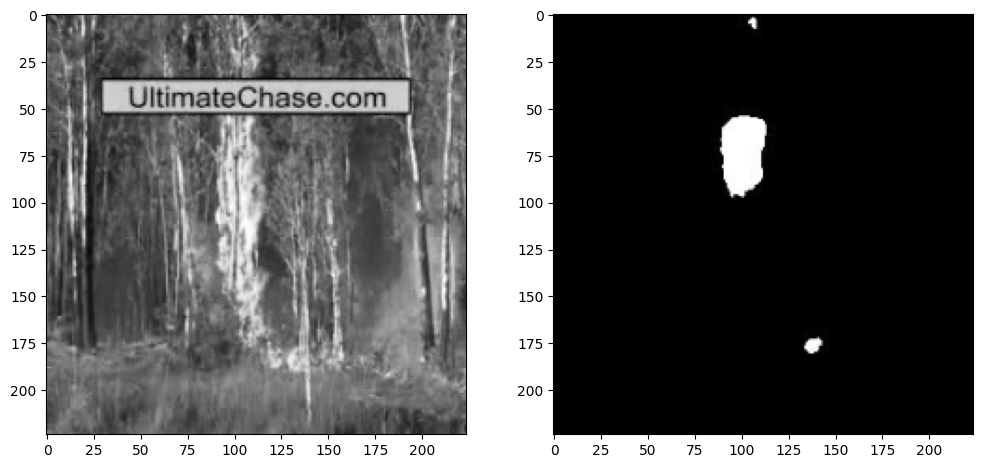

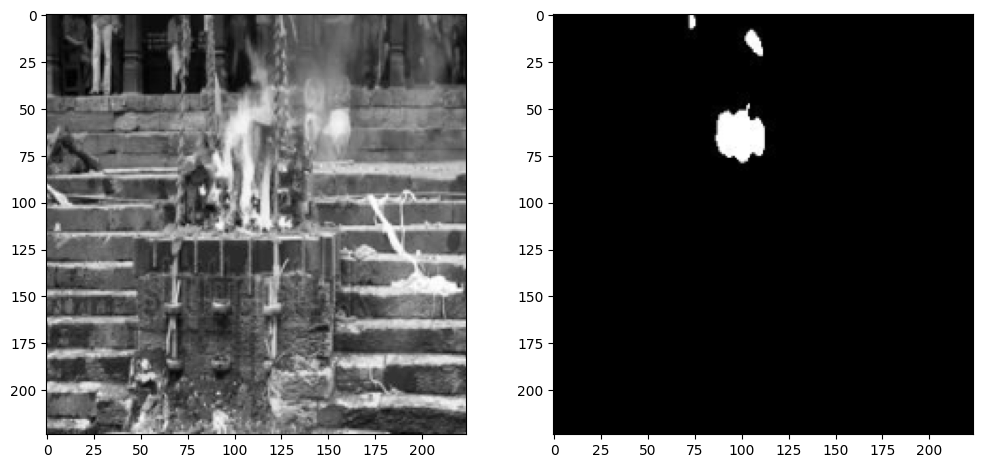

In [15]:
k = 1
for i, j in val_dataset.take(2):
    plt.figure(figsize=(12, 12))
    plt.subplot(2, 2, k)
    plt.imshow(i, cmap='grey')
    plt.subplot(2, 2, k+1)
    plt.imshow(j, cmap='grey')
    k+=2

In [16]:
train_dataset = (train_dataset
                 .batch(CONFIGURATION['BATCH SIZE'])
                 .shuffle(256, reshuffle_each_iteration=False)
                 .prefetch(tf.data.AUTOTUNE))

In [17]:
val_dataset = (val_dataset
                 .batch(CONFIGURATION['BATCH SIZE'])
                #  .shuffle(128, reshuffle_each_iteration=False)
                 .prefetch(tf.data.AUTOTUNE))

In [18]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None))>

# Model Create

In [19]:
input = Input(shape=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'], 1), name='Input Image')
# layers increasing
conv1 = Conv2D(CONFIGURATION['H_NRNS']*1, (3, 3), activation='relu', padding='same')(input)
conv1 = Conv2D(CONFIGURATION['H_NRNS']*1, (3, 3), activation='relu', padding='same')(conv1)
maxpool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
maxpool1 = Dropout(0.25)(maxpool1)

conv2 = Conv2D(CONFIGURATION['H_NRNS']*2, (3, 3), activation='relu', padding='same')(maxpool1)
conv2 = Conv2D(CONFIGURATION['H_NRNS']*2, (3, 3), activation='relu', padding='same')(conv2)
maxpool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
maxpool2 = Dropout(0.25)(maxpool2)

conv3 = Conv2D(CONFIGURATION['H_NRNS']*4, (3, 3), activation='relu', padding='same')(maxpool2)
conv3 = Conv2D(CONFIGURATION['H_NRNS']*4, (3, 3), activation='relu', padding='same')(conv3)
maxpool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
maxpool3 = Dropout(0.25)(maxpool3)

conv4 = Conv2D(CONFIGURATION['H_NRNS']*8, (3, 3), activation='relu', padding='same')(maxpool3)
conv4 = Conv2D(CONFIGURATION['H_NRNS']*8, (3, 3), activation='relu', padding='same')(conv4)
maxpool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
maxpool4 = Dropout(0.25)(maxpool4)

#middle layers
convm = Conv2D(CONFIGURATION['H_NRNS']*16, (3, 3), activation='relu', padding='same')(maxpool4)
convm = Conv2D(CONFIGURATION['H_NRNS']*16, (3, 3), activation='relu', padding='same')(convm)

# layers decrsing
deconv4 = Conv2DTranspose(CONFIGURATION['H_NRNS']*8, (3, 3),strides=(2, 2), activation='relu', padding='same')(convm)
uconv4 = concatenate([conv4, deconv4])
uconv4 = Dropout(0.5)(uconv4)
uconv4 = Conv2D(CONFIGURATION['H_NRNS']*8, (3, 3), activation='relu', padding='same')(uconv4)
uconv4 = Conv2D(CONFIGURATION['H_NRNS']*8, (3, 3), activation='relu', padding='same')(uconv4)

deconv3 = Conv2DTranspose(CONFIGURATION['H_NRNS']*4, (3, 3),strides=(2, 2), activation='relu', padding='same')(uconv4)
uconv3 = concatenate([conv3, deconv3])
uconv3 = Dropout(0.5)(uconv3)
uconv3 = Conv2D(CONFIGURATION['H_NRNS']*4, (3, 3), activation='relu', padding='same')(uconv3)
uconv3 = Conv2D(CONFIGURATION['H_NRNS']*4, (3, 3), activation='relu', padding='same')(uconv3)

deconv2 = Conv2DTranspose(CONFIGURATION['H_NRNS']*2, (3, 3),strides=(2, 2), activation='relu', padding='same')(uconv3)
uconv2 = concatenate([conv2, deconv2])
uconv2 = Dropout(0.5)(uconv2)
uconv2 = Conv2D(CONFIGURATION['H_NRNS']*2, (3, 3), activation='relu', padding='same')(uconv2)
uconv2 = Conv2D(CONFIGURATION['H_NRNS']*2, (3, 3), activation='relu', padding='same')(uconv2)

deconv1 = Conv2DTranspose(CONFIGURATION['H_NRNS'], (3, 3),strides=(2, 2), activation='relu', padding='same')(uconv2)
uconv1 = concatenate([conv1, deconv1])
uconv1 = Dropout(0.5)(uconv1)
uconv1 = Conv2D(CONFIGURATION['H_NRNS'], (3, 3), activation='relu', padding='same')(uconv1)
uconv1 = Conv2D(CONFIGURATION['H_NRNS'], (3, 3), activation='relu', padding='same')(uconv1)

output = Conv2D(1, (1, 1), padding='same', activation='sigmoid')(uconv1)


model = Model(input, output)

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input Image (InputLayer)    [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 16)         160       ['Input Image[0][0]']         
                                                                                                  
 conv2d_1 (Conv2D)           (None, 224, 224, 16)         2320      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [21]:
model.compile(
    optimizer=Adam(),
    loss=BinaryCrossentropy(),
    # run_eagerly=True
)

In [22]:
save_model = [
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('unet_model.keras', verbose=1, save_best_only=True, save_weights_only=True)
]

### model reun

In [23]:
history = model.fit(train_dataset, validation_data=val_dataset,epochs=CONFIGURATION['N_EPOCH'], verbose=1, callbacks=save_model)

Epoch 1/50


2023-11-08 00:57:51.813327: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-11-08 00:58:02.160286: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 142 of 256
2023-11-08 00:58:10.267380: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2023-11-08 00:58:10.290814: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-08 00:58:14.325578: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 677.57MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-11-08 00:58:14.512841: W tensorflo

1196/1196 [==============================] - ETA: 0s - loss: 0.0534
Epoch 1: val_loss improved from inf to 0.05904, saving model to unet_model.keras
1196/1196 [==============================] - 756s 603ms/step - loss: 0.0534 - val_loss: 0.0590 - lr: 0.0010
Epoch 2/50


2023-11-08 01:10:34.953196: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 128 of 256
2023-11-08 01:10:44.640538: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1196/1196 [==============================] - ETA: 0s - loss: 0.0562
Epoch 2: val_loss improved from 0.05904 to 0.05845, saving model to unet_model.keras
1196/1196 [==============================] - 735s 598ms/step - loss: 0.0562 - val_loss: 0.0584 - lr: 0.0010
Epoch 3/50


2023-11-08 01:22:49.455543: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 126 of 256
2023-11-08 01:22:59.476319: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1196/1196 [==============================] - ETA: 0s - loss: 0.0595
Epoch 3: val_loss improved from 0.05845 to 0.04863, saving model to unet_model.keras
1196/1196 [==============================] - 726s 590ms/step - loss: 0.0595 - val_loss: 0.0486 - lr: 0.0010
Epoch 4/50


2023-11-08 01:34:55.705588: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 127 of 256
2023-11-08 01:35:05.769589: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1196/1196 [==============================] - ETA: 0s - loss: 0.0419
Epoch 4: val_loss improved from 0.04863 to 0.04225, saving model to unet_model.keras
1196/1196 [==============================] - 727s 591ms/step - loss: 0.0419 - val_loss: 0.0422 - lr: 0.0010
Epoch 5/50


2023-11-08 01:47:03.140021: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 126 of 256
2023-11-08 01:47:13.273627: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1196/1196 [==============================] - ETA: 0s - loss: 0.0382
Epoch 5: val_loss improved from 0.04225 to 0.04196, saving model to unet_model.keras
1196/1196 [==============================] - 726s 590ms/step - loss: 0.0382 - val_loss: 0.0420 - lr: 0.0010
Epoch 6/50


2023-11-08 01:59:09.214653: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 124 of 256
2023-11-08 01:59:19.565936: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1196/1196 [==============================] - ETA: 0s - loss: 0.0313
Epoch 6: val_loss did not improve from 0.04196
1196/1196 [==============================] - 733s 596ms/step - loss: 0.0313 - val_loss: 0.0472 - lr: 0.0010
Epoch 7/50


2023-11-08 02:11:22.554931: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 122 of 256
2023-11-08 02:11:32.566780: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 252 of 256
2023-11-08 02:11:32.860643: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1196/1196 [==============================] - ETA: 0s - loss: 0.0257
Epoch 7: val_loss improved from 0.04196 to 0.03702, saving model to unet_model.keras
1196/1196 [==============================] - 733s 596ms/step - loss: 0.0257 - val_loss: 0.0370 - lr: 0.0010
Epoch 8/50


2023-11-08 02:23:35.637606: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 122 of 256
2023-11-08 02:23:45.764960: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1196/1196 [==============================] - ETA: 0s - loss: 0.0232
Epoch 8: val_loss did not improve from 0.03702
1196/1196 [==============================] - 728s 592ms/step - loss: 0.0232 - val_loss: 0.0430 - lr: 0.0010
Epoch 9/50


2023-11-08 02:35:43.713549: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 121 of 256
2023-11-08 02:35:54.470463: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1196/1196 [==============================] - ETA: 0s - loss: 0.0257
Epoch 9: val_loss did not improve from 0.03702
1196/1196 [==============================] - 725s 589ms/step - loss: 0.0257 - val_loss: 0.0622 - lr: 0.0010
Epoch 10/50


2023-11-08 02:47:49.047028: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 121 of 256
2023-11-08 02:47:59.622550: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1196/1196 [==============================] - ETA: 0s - loss: 0.0388
Epoch 10: val_loss did not improve from 0.03702
1196/1196 [==============================] - 736s 598ms/step - loss: 0.0388 - val_loss: 0.0574 - lr: 0.0010
Epoch 11/50


2023-11-08 03:00:04.661474: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 123 of 256
2023-11-08 03:00:15.085246: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1196/1196 [==============================] - ETA: 0s - loss: 0.0232
Epoch 11: val_loss did not improve from 0.03702
1196/1196 [==============================] - 730s 593ms/step - loss: 0.0232 - val_loss: 0.0560 - lr: 0.0010
Epoch 12/50


2023-11-08 03:12:14.393908: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 122 of 256
2023-11-08 03:12:24.426338: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 248 of 256
2023-11-08 03:12:25.022236: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1196/1196 [==============================] - ETA: 0s - loss: 0.0206
Epoch 12: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 12: val_loss did not improve from 0.03702
1196/1196 [==============================] - 726s 590ms/step - loss: 0.0206 - val_loss: 0.0478 - lr: 0.0010
Epoch 13/50


2023-11-08 03:24:20.447096: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 122 of 256
2023-11-08 03:24:30.947877: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1196/1196 [==============================] - ETA: 0s - loss: 0.0181
Epoch 13: val_loss did not improve from 0.03702
1196/1196 [==============================] - 724s 588ms/step - loss: 0.0181 - val_loss: 0.0413 - lr: 1.0000e-04
Epoch 14/50


2023-11-08 03:36:24.225563: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 123 of 256
2023-11-08 03:36:34.240697: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 253 of 256
2023-11-08 03:36:34.468288: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1196/1196 [==============================] - ETA: 0s - loss: 0.0174
Epoch 14: val_loss did not improve from 0.03702
1196/1196 [==============================] - 730s 594ms/step - loss: 0.0174 - val_loss: 0.0436 - lr: 1.0000e-04
Epoch 15/50


2023-11-08 03:48:34.423077: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 123 of 256
2023-11-08 03:48:44.805140: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1196/1196 [==============================] - ETA: 0s - loss: 0.0171
Epoch 15: val_loss did not improve from 0.03702
1196/1196 [==============================] - 728s 591ms/step - loss: 0.0171 - val_loss: 0.0466 - lr: 1.0000e-04
Epoch 16/50


2023-11-08 04:00:41.957093: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 121 of 256
2023-11-08 04:00:52.009972: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 247 of 256
2023-11-08 04:00:52.729681: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1196/1196 [==============================] - ETA: 0s - loss: 0.0168
Epoch 16: val_loss did not improve from 0.03702
1196/1196 [==============================] - 726s 589ms/step - loss: 0.0168 - val_loss: 0.0483 - lr: 1.0000e-04
Epoch 17/50


2023-11-08 04:12:47.511489: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 124 of 256
2023-11-08 04:12:57.583452: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 251 of 256
2023-11-08 04:12:57.939838: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1196/1196 [==============================] - ETA: 0s - loss: 0.0165
Epoch 17: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 17: val_loss did not improve from 0.03702
1196/1196 [==============================] - 724s 588ms/step - loss: 0.0165 - val_loss: 0.0502 - lr: 1.0000e-04
Epoch 18/50


2023-11-08 04:24:51.450974: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 123 of 256
2023-11-08 04:25:01.978864: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1196/1196 [==============================] - ETA: 0s - loss: 0.0163
Epoch 18: val_loss did not improve from 0.03702
1196/1196 [==============================] - 729s 593ms/step - loss: 0.0163 - val_loss: 0.0450 - lr: 1.0000e-05
Epoch 19/50


2023-11-08 04:37:00.580537: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 119 of 256
2023-11-08 04:37:10.592008: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 244 of 256
2023-11-08 04:37:11.491876: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1196/1196 [==============================] - ETA: 0s - loss: 0.0162
Epoch 19: val_loss did not improve from 0.03702
1196/1196 [==============================] - 727s 591ms/step - loss: 0.0162 - val_loss: 0.0440 - lr: 1.0000e-05
Epoch 20/50


2023-11-08 04:49:07.995381: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 123 of 256
2023-11-08 04:49:18.473412: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1196/1196 [==============================] - ETA: 0s - loss: 0.0161
Epoch 20: val_loss did not improve from 0.03702
1196/1196 [==============================] - 724s 588ms/step - loss: 0.0161 - val_loss: 0.0439 - lr: 1.0000e-05
Epoch 21/50


2023-11-08 05:01:11.804835: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 123 of 256
2023-11-08 05:01:21.814471: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 252 of 256
2023-11-08 05:01:22.091940: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1196/1196 [==============================] - ETA: 0s - loss: 0.0161
Epoch 21: val_loss did not improve from 0.03702
1196/1196 [==============================] - 724s 588ms/step - loss: 0.0161 - val_loss: 0.0438 - lr: 1.0000e-05
Epoch 22/50


2023-11-08 05:13:15.572950: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 126 of 256
2023-11-08 05:13:25.615882: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 253 of 256
2023-11-08 05:13:25.875057: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1196/1196 [==============================] - ETA: 0s - loss: 0.0161
Epoch 22: ReduceLROnPlateau reducing learning rate to 1e-05.

Epoch 22: val_loss did not improve from 0.03702
1196/1196 [==============================] - 731s 594ms/step - loss: 0.0161 - val_loss: 0.0444 - lr: 1.0000e-05
Epoch 23/50


2023-11-08 05:25:26.264628: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 120 of 256
2023-11-08 05:25:36.282832: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 242 of 256
2023-11-08 05:25:37.355961: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1196/1196 [==============================] - ETA: 0s - loss: 0.0161
Epoch 23: val_loss did not improve from 0.03702
1196/1196 [==============================] - 728s 591ms/step - loss: 0.0161 - val_loss: 0.0440 - lr: 1.0000e-05
Epoch 24/50


2023-11-08 05:37:33.993763: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 123 of 256
2023-11-08 05:37:44.003867: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 248 of 256
2023-11-08 05:37:44.671142: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1196/1196 [==============================] - ETA: 0s - loss: 0.0161
Epoch 24: val_loss did not improve from 0.03702
1196/1196 [==============================] - 724s 588ms/step - loss: 0.0161 - val_loss: 0.0437 - lr: 1.0000e-05
Epoch 25/50


2023-11-08 05:49:38.484883: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 124 of 256
2023-11-08 05:49:48.495453: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 252 of 256
2023-11-08 05:49:48.798173: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1196/1196 [==============================] - ETA: 0s - loss: 0.0160
Epoch 25: val_loss did not improve from 0.03702
1196/1196 [==============================] - 726s 590ms/step - loss: 0.0160 - val_loss: 0.0438 - lr: 1.0000e-05
Epoch 26/50


2023-11-08 06:01:44.505206: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 119 of 256
2023-11-08 06:01:55.418904: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1196/1196 [==============================] - ETA: 0s - loss: 0.0160
Epoch 26: val_loss did not improve from 0.03702
1196/1196 [==============================] - 732s 594ms/step - loss: 0.0160 - val_loss: 0.0437 - lr: 1.0000e-05
Epoch 27/50


2023-11-08 06:13:56.138892: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 121 of 256
2023-11-08 06:14:06.777887: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1196/1196 [==============================] - ETA: 0s - loss: 0.0159
Epoch 27: val_loss did not improve from 0.03702
1196/1196 [==============================] - 728s 591ms/step - loss: 0.0159 - val_loss: 0.0442 - lr: 1.0000e-05
Epoch 28/50


2023-11-08 06:26:04.076926: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 118 of 256
2023-11-08 06:26:14.096613: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 245 of 256
2023-11-08 06:26:14.978881: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1196/1196 [==============================] - ETA: 0s - loss: 0.0159
Epoch 28: val_loss did not improve from 0.03702
1196/1196 [==============================] - 725s 589ms/step - loss: 0.0159 - val_loss: 0.0441 - lr: 1.0000e-05
Epoch 29/50


2023-11-08 06:38:09.066666: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 124 of 256
2023-11-08 06:38:19.459908: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1196/1196 [==============================] - ETA: 0s - loss: 0.0159
Epoch 29: val_loss did not improve from 0.03702
1196/1196 [==============================] - 729s 593ms/step - loss: 0.0159 - val_loss: 0.0435 - lr: 1.0000e-05
Epoch 30/50


2023-11-08 06:50:18.390390: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 112 of 256
2023-11-08 06:50:30.564149: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


  18/1196 [..............................] - ETA: 12:29 - loss: 0.0234

KeyboardInterrupt: 

# Testing

In [24]:
model.load_weights('./unet_model.keras')

In [37]:
image = cv2.imread('./dataset/val_image/Not_Fire/Img_1631.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = cv2.resize(image, (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']))
image = np.expand_dims(image, -1)/255

image = np.expand_dims(image, axis=0)

res = model.predict(image)

1/1 [==============================] - 0s 21ms/step


In [42]:
orig = cv2.imread('./dataset/val_image/Not_Fire/Img_1631.jpg')
img = cv2.resize(orig, (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']))
img = np.expand_dims(img, 0)
print(img.shape)

(1, 224, 224, 3)


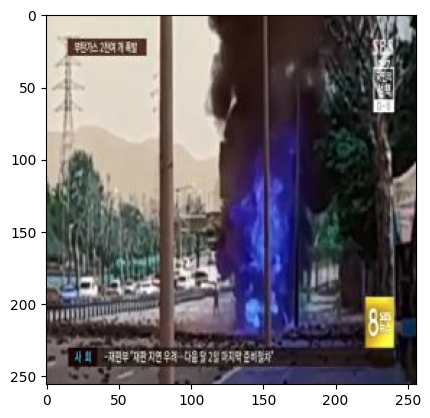

In [39]:
actual=cv2.imread('./dataset/val_image/Not_Fire/Img_1631.jpg')
plt.imshow(actual)